In [1]:
import argparse
import copy
import os
import sys

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3
import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.signal.pulse import EnvelopeDrag
from c3.utils.tf_utils import tf_project_to_comp
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *
from four_level_transmons.blackbox import generateSignalFromConfig
tf.config.run_functions_eagerly(True)
np.set_printoptions(linewidth=300)

2022-06-27 13:23:55.855747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 13:23:55.855794: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"
output = DataOutput(output_dir, file_suffix='before')

=========== WARNING: no output directory specified ============


In [3]:
# general settings
numPWCPieces = 60
usePWC = False
useDRAG = True
t_final = 500e-9
sim_res = 20e9
awg_res = numPWCPieces / t_final if usePWC else 50e9
isDressed = True

ALGORITHM_LBFGS = 0
ALGORITHM_LBFGS_GRAD_FREE = 1
ALGORITHM_CMAES = 2
ALGORITHM_GCMAES = 3
selected_algorithms = [ALGORITHM_LBFGS]

In [4]:
entanglementInitState = [0, 1]
entanglementInitStateFull = [0, 1]

def printSignal(exper: Experiment, qubits: List[chip.Qubit],
                gate: gates.Instruction, output: DataOutput,
                states: List[Tuple[float, str]] = None):
    signals = exper.pmap.generator.generate_signals(gate)
    for i, qubit in enumerate(qubits):
        # generate signal
        drive = getDrive(exper.pmap.model, qubit).name
        signal = signals[drive]
        ts = signal["ts"].numpy()
        values = signal["values"].numpy()

        # save data
        peakFrequencies, peakValues = findFrequencyPeaks(ts, values, 10, normalise=False)
        sortIndices = np.argsort(peakValues)
        print(f"peaks: {drive}")
        for idx in sortIndices:
            print(f"\t{peakFrequencies[idx]:e} (amp={peakValues[idx]:e})")
        output.save([ts, values], f"signal_t{i + 1}")

        # plot
        plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_t{i + 1}", "svg"),
                              spectralThreshold=None)
        plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_detail_t{i + 1}", "svg"),
                              spectralThreshold=1e-4)
        plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_detail_states_t{i + 1}", "svg"),
                              spectralThreshold=1e-4, states=states)
        #plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_detail_with_states_t{i + 1}", "svg"),
        #                      states=states,
        #                      spectralThreshold=1e-4)


def printTimeEvolution(exper: Experiment, init: tf.Tensor, gate: gates.Instruction,
                       labels: List[str], output: DataOutput):
    populations = calculatePopulation(exper, init, [gate.get_key()])
    output.save(populations, "population")
    plotPopulation(exper, populations, sequence=[gate.get_key()],
                   labels=labels, filename=output.createFileName("population", "svg"))
    plotSplittedPopulation(exper, populations, [gate.get_key()], filename=output.createFileName("population", "svg"))


def stateEntropyAB(state: tf.Tensor):
    rho = densityMatrix(state)
    if state.shape[0] > 16:
        rho = tf_project_to_comp(rho, dims=qubit_levels, outdims=[4, 4])
    rhoBD = tf_project_to_comp(rho, dims=[2, 2, 2, 2], outdims=[0, 2, 0, 2])
    #rhoBD = partialTrace(rho, [1, 3])
    rhoB = partialTrace(rhoBD, [0])
    #rhoAB = partialTrace(rho, [0, 1])
    return entanglementEntropy(rhoB)  #- entanglementEntropy(rhoBD)


def printEntanglementEvolution(exper: Experiment, gate: gates.Instruction, output: DataOutput):
    entropies = []
    #for state in [(0, 1), (0, 5), (1, 6), (5, 6)]:
    for state in [(0, 1), (0, 4), (1, 5), (4, 5)]:
    #for state in [(0, 4), (5, 6), (10, 11), (12, 13)]:
        psi_init = np.zeros(shape=(model.tot_dim,))
        psi_init[state[0]] = psi_init[state[1]] = 1 / np.sqrt(2)
        entropy = calculateObservable(exper, np.array(psi_init), [gate.get_key()], stateEntropyAB)
        entropies.append(entropy)
    entropies = np.array(entropies)
    plotPopulation(exper, entropies, sequence=[gate.get_key()],
                   labels=["00+01", "00+10", "01+11", "10+11"],
                   filename=output.createFileName("entanglement", "svg"),
                   labelY="Entropy")


def printMatrix(M: np.array, labels: List[str], name: str, output: DataOutput):
    #plotComplexMatrix(M, xlabels=labels, ylabels=labels, filename=output.createFileName(name))
    plotComplexMatrixHinton(M, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                            filename=output.createFileName(name, "svg"), colourMap='hsv')
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=True,
    #                            filename=output.createFileName(name + "_phase"))
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=False,
    #                            filename=output.createFileName(name + "_abs"))


def printPropagator(exper: Experiment, gate: gates.Instruction,
                    labels: List[str], output: DataOutput,
                    savePartials=False):
    U = exper.propagators[gate.get_key()]
    output.save(U, "propagator")
    #output.save(exper.partial_propagators[gate.get_key()], "partial_propagators")
    #os.system('bzip2 -9 "' + output.createFileName('partial_propagators.npy') + '"')
    printMatrix(U, labels, "propagator", output)
    if savePartials:
        output.save(exper.partial_propagators[gate.get_key()], "partial_propagators")


def printAllSignals(exper: Experiment, qubit: chip.Qubit, output: DataOutput, directory: str):
    try:
        os.mkdir(output.getDirectory() + "/" + directory)
    except:
        pass
    drive = getDrive(exper.pmap.model, qubit)
    outputs = exper.pmap.generator.global_signal_stack[drive.name]

    for name, values in outputs.items():
        filename = output.createFileName(directory + f"/device_{drive.name}_{name}", "svg")
        time = values["ts"].numpy()
        #if name.startswith("AWG"):
        #    re = values["inphase"].numpy()
        #    im = values["quadrature"].numpy()
        #    plotSignalAndSpectrum(time[:1000], real=re[:1000], min_signal_limit=None,
        #                          spectralThreshold=5e-4,
        #                          filename=output.createFileName(directory + f"/device_{drive.name}_{name}_real", "svg"))
        #    plotSignalAndSpectrum(time[:1000], real=im[:1000], min_signal_limit=None,
        #                          spectralThreshold=5e-4,
        #                          filename=output.createFileName(directory + f"/device_{drive.name}_{name}_imag", "svg"))

        print(name+":")
        if "values" in values:
            signal = values["values"].numpy()
            plotSignalAndSpectrum(time, signal, min_signal_limit=None, filename=filename, spectralThreshold=None)
        else:
            plotSignalAndSpectrum(time, real=values["inphase"].numpy(), imag=values["quadrature"].numpy(),
                                  min_signal_limit=None, spectralThreshold=None, filename=filename)

'''
def entanglementStateGoal(actual: tf.constant, index, dims, active_levels):
    dim = active_levels ** len(dims)
    actual_comp = tf_project_to_comp(
        actual, dims=dims, index=index, outdims=[active_levels] * len(dims)
    )
    entropies = []
    for state in [(0, 4)]: #, (0, 1), (1, 5), (4, 5)]:
        psi_init = [[0] * dim]
        psi_init[0][state[0]] = psi_init[0][state[1]] = 1.0 / np.sqrt(2)
        init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
        #psi = np.zeros((dim, 1))
        #psi[state[0], 0] = psi[state[1], 0] = 1 / np.sqrt(2)
        #psi_init = tf.constant(psi, dtype=actual_comp.dtype)
        #init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
        psi_actual = tf.matmul(actual_comp, init_state)
        rho = densityMatrix(psi_actual)

        # S(B) - S(BD)
        rhoBD = partialTrace(rho, [1, 3])
        #entropyBD = entanglementEntropy(rhoBD)
        rhoB = partialTrace(rhoBD, [0])
        entropyB = entanglementEntropy(rhoB)
        entropies.append(entropyB)

        # S(AB)
        #rhoAB = partialTrace(rho, [0, 1])
        #entropies.append(entanglementEntropy(rhoAB) / 2)
    return 1 - np.max(entropies)
'''

def entanglementStateGoalTF(actual: tf.constant, index, dims, active_levels):
    dim = active_levels ** len(dims)
    actual_comp = tf_project_to_comp(
        actual, dims=dims, index=index, outdims=[active_levels] * len(dims)
    )

    # initial and final state
    psi = np.zeros((dim, 1))
    for i in entanglementInitState:
        psi[i, 0] = 1
    psi /= np.linalg.norm(psi)
    psi_init = tf.constant(psi, dtype=actual_comp.dtype)
    psi_actual = tf.matmul(actual_comp, psi_init)
    rho = densityMatrixTF(psi_actual[:, 0])

    # calculate entropy
    rhoBD = tf_project_to_comp(rho, dims=[2, 2, 2, 2], outdims=[0, 2, 0, 2])
    #rhoBD = partialTraceTF(rho, [1, 3])
    #entropyBD = entanglementEntropyTF(rhoBD) / 2
    rhoB = partialTraceTF(rhoBD, [0])
    entropyB = entanglementEntropyTF(rhoB)
    #return (1.0 - entropyB + entropyBD) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))
    return (1.0 - entropyB) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))

    #rhoAB = partialTraceTF(rho, [0, 1])
    #entropyAB = entanglementEntropyTF(rhoAB)
    #return (2.0 - entropyAB) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))


def entanglementGoal(propagators: dict, instructions: dict, index, dims, active_levels=2, n_eval=-1):
    infids = []
    for gate, propagator in propagators.items():
        infid = entanglementStateGoalTF(propagator, index, dims, active_levels)
        infids.append(infid)
    return tf.reduce_mean(infids)


def optimise(output: DataOutput, qubits: List[chip.PhysicalComponent],
             exp: Experiment, algorithm, options, gate: gates.Instruction) -> List[float]:
    # set up the optimiser
    opt = OptimalControl(
        dir_path=output.getDirectory(),
        fid_func=fidelities.unitary_infid_set,
        #fid_func=entanglementGoal,
        fid_subspace=[q.name for q in qubits],
        pmap=exp.pmap,
        algorithm=algorithm,
        options=options,
        run_name=gate.name,
        fid_func_kwargs={
            "active_levels": 4,
            "signalFidelityCoef": None,
        }
    )
    exp.set_opt_gates([gate.get_key()])
    opt.set_exp(exp)

    # add the callback
    infidelities = []

    def fidelityCallback(index, fidelity):
        print(index, fidelity)
        infidelities.append(fidelity)

    opt.set_callback(fidelityCallback)

    # run optimisation
    opt.optimize_controls()
    print(opt.current_best_goal)
    exp.pmap.print_parameters()

    return infidelities

In [5]:
# coupling=30: f=4.6, anh=-200; f=4.32, anh=-350
# f=4.5: anh=-200, coupling=33
# Initialise the qubits and drive lines
qubit_levels = [4, 4]
qubit_frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -250e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]
couplingStrength = 20e6
print("qubits frequencies: ", qubit_frequencies, "anharmonicities: ", anharmonicities,
      "coupling: ", couplingStrength)

level_labels_transmon = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle"]
for i in range(len(level_labels_transmon), max(qubit_levels)):
    level_labels_transmon.append("leakage")
level_labels = []
level_labels_with_leakage = []
level_labels_short = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels_with_leakage.append("leakage")
            level_labels_short.append(None)
        else:
            s = f"${level_labels_transmon[i]},{level_labels_transmon[j]}$"
            level_labels.append(s)
            level_labels_with_leakage.append(s)
            level_labels_short.append(f"{i},{j}")
level_labels_transmon = [f"${x}$" for x in level_labels_transmon]

qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities,
                         t1s, t2stars, qubit_temps)
coupling = createChainCouplings([couplingStrength], qubits)
drives = createDrives(qubits)

qubits frequencies:  [5000000000.0, 4500000000.0] anharmonicities:  [-300000000.0, -250000000.0] coupling:  20000000.0


2022-06-27 13:23:58.728548: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-27 13:23:58.728589: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 13:23:58.728605: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-06-27 13:23:58.729305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Create the model
model = Mdl(qubits, coupling + drives)
model.set_lindbladian(False)
model.set_dressed(isDressed)
model.set_FR(False)

#energies = model.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi)
#print("energies: ", energies)
qubitEnergies = [q.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi) for q in qubits]
qubitEnergies[0] = qubitEnergies[0][::qubit_levels[0]]
qubitEnergies[1] = qubitEnergies[1][:qubit_levels[1]]
qubitTransitions = [np.array([e[i + 1] - e[i] for i in range(len(e) - 1)]) for e in qubitEnergies]
for i in range(len(qubits)):
    print(f"Qubit {i}:")
    print(qubitEnergies[i])
    print(qubitTransitions[i])

Qubit 0:
[0.00e+00 5.00e+09 9.70e+09 1.41e+10]
[5.0e+09 4.7e+09 4.4e+09]
Qubit 1:
[0.000e+00 4.500e+09 8.750e+09 1.275e+10]
[4.50e+09 4.25e+09 4.00e+09]


In [7]:
# all energy levels with labels
stateEnergies = []
H = model.get_Hamiltonian().numpy()
evals,evecs = scipy.linalg.eig(H)
evals = evals.real / (2 * np.pi)
indices = [np.argmax(np.round(evecs[i], 2)) for i in range(len(evals))]
for i, x in enumerate(level_labels_short):
    if level_labels_short[i] is not None:
        energy = evals[indices[i]]
        stateEnergies.append((energy, x))

# all energy transitions
items = sorted(stateEnergies, key=lambda x: x[0])
transitions = []
for i in range(len(items)):
    for j in range(len(items)):
        if i != j:
            #print(i, j)
            E = items[j][0] - items[i][0]
            if E > 0:
                transitions.append((E, items[i][1] + " - " + items[j][1]))

In [8]:
def getFourierBasisFromDirectTransitions(qubitTransitions):
    allTransitions = [qubitTransitions[0][0], qubitTransitions[0][1], qubitTransitions[0][2], qubitTransitions[1][0], qubitTransitions[1][1], qubitTransitions[1][2]]
    allAmps = [0.2, 0.02, 0.2, 1, 0.1, 1]
    selectedFreqsMap = {"d1": np.array(allTransitions), "d2": np.array(allTransitions)}
    selectedAmpsMap = {"d1": 1e8 * np.array(allAmps), "d2": 1e7 * np.array(allAmps)}
    selectedPhasesMap = {"d1": np.zeros_like(allTransitions), "d2": np.zeros_like(allTransitions)}
    return selectedFreqsMap, selectedAmpsMap, selectedPhasesMap

def getFourierBasisFromModel(levelTransitions: List[float], spectralRange: Tuple[float,float]=(3.6e9,5.0e9)) -> Tuple[Dict, Dict, Dict]:
    selectedFrequencies = []
    for t in levelTransitions:
        if spectralRange[0] < t[0] < spectralRange[1]:
            selectedFrequencies.append(t[0])
            print(t)
    selectedFrequencies = np.sort(selectedFrequencies)
    selectedFreqsMap = {"d1": selectedFrequencies, "d2": selectedFrequencies}
    selectedAmpsMap = {"d1": 0.5e8 * np.ones_like(selectedFrequencies), "d2": 0.5e7 * np.ones_like(selectedFrequencies)}
    selectedPhasesMap = {"d1": 0.1 * np.ones_like(selectedFrequencies), "d2": 0.1 * np.ones_like(selectedFrequencies)}
    print(len(selectedFrequencies))
    return selectedFreqsMap, selectedAmpsMap, selectedPhasesMap

def getFourierBasisFromSignal(filename: str) -> Tuple[Dict, Dict, Dict]:
    stored_pmap = PMap()
    stored_pmap.read_config(filename)
    stored_params = stored_pmap.asdict()[list(stored_pmap.asdict().keys())[0]]
    stored_signal = generateSignalFromConfig(stored_params, sim_res=sim_res, awg_res=numPWCPieces / t_final, useDRAG=False,
                                         usePWC=True, numPWCPieces=60, t_final=t_final)
    selectedFreqsMap = {}
    selectedAmpsMap = {}
    selectedPhasesMap = {}
    for i, drive in enumerate(list(stored_signal.keys())):
        signal = stored_signal[drive]

        ts = signal["ts"].numpy()
        values = signal["values"].numpy()
        freq = np.fft.rfftfreq(len(ts), ts[-1] / len(ts))[1:]
        freq_signal = np.fft.rfft(values)[1:]
        #freq = np.fft.rfftfreq(len(ts), ts[-1] / len(ts))
        #freq_signal = np.abs(np.fft.rfft(values))
        #peaks, amps = findFrequencyPeaks(signal["ts"].numpy(), signal["values"].numpy(), 50, normalise=True)
        selectedFreqsMap[drive] = freq
        selectedAmpsMap[drive] = np.abs(freq_signal)
        selectedPhasesMap[drive] = np.angle(freq_signal)
        print("selected frequencies: ", len(selectedFreqsMap[drive]))
        print(selectedFreqsMap[drive])
    return selectedFreqsMap, selectedAmpsMap, selectedPhasesMap

def getConfigurationFromFile(filename: str, spectralRange: Tuple[float,float], numPeaks: int) -> Dict:
    stored_pmap = PMap()
    stored_pmap.read_config(filename)
    stored_params = stored_pmap.asdict()[list(stored_pmap.asdict().keys())[0]]
    driveChannels = stored_params["drive_channels"]
    for driveName, drive in driveChannels.items():
        envelope = drive[f"envelope_{driveName}"]
        freqs = envelope.params["freqs"].get_value().numpy() / (2 * np.pi)
        amps = envelope.params["amps"].get_value().numpy()
        phases = envelope.params["phases"].get_value().numpy()

        # restrict to spectral range
        if spectralRange is not None:
            indices = np.all([freqs > spectralRange[0], freqs < spectralRange[1]], 0)
            freqs = freqs[indices]
            amps = amps[indices]
            phases = phases[indices]
            print(f"Drive {driveName}: after restriction to range: {len(indices)}")

        # find peaks
        #if numPeaks is not None and numPeaks > 0:
        #    peaks = find_peaks(amps)[0]
        #    freqs = freqs[peaks]
        #    amps = amps[peaks]
        #    phases = phases[peaks]
        #    print(f"Drive {driveName}: peaks found: {len(peaks)}")

        # use largest N peaks
        if numPeaks is not None and numPeaks > 0:
            maxIndices = amps.argsort()[-numPeaks:][::-1]
            freqs = freqs[maxIndices]
            amps = amps[maxIndices]
            phases = phases[maxIndices]
            print(f"Drive {driveName}: selected indices {len(maxIndices)}")

        envelope.params["freqs"] = Qty(value=freqs, min_val=0.95 * freqs, max_val=1.05 * freqs, unit="Hz 2pi")
        envelope.params["amps"] = Qty(value=amps, min_val=1e-2 * amps, max_val=1e2 * amps, unit="V")
        envelope.params["phases"] = Qty(value=phases, min_val=-np.pi * np.ones_like(phases), max_val=np.pi * np.ones_like(phases), unit="rad")
        print(f"frequencies {driveName}: {freqs[0]:e} {freqs[-1]:e} {len(freqs)}")
    return stored_params

stored_params = getConfigurationFromFile("./optimised_params/10freqsvariable_from15_CZ.json", spectralRange=(3.5e9, 5.5e9), numPeaks=8)

Drive d1: after restriction to range: 10
Drive d1: selected indices 10
frequencies d1: 4.524952e+09 4.763255e+09 10
Drive d2: after restriction to range: 10
Drive d2: selected indices 10
frequencies d2: 4.527089e+09 4.539101e+09 10


In [9]:
# Create the generator
generator = createGenerator(drives, sim_res=sim_res, awg_res=awg_res, highpass_cutoff_freq=-1, lowpass_cutoff_freq=5.2e9, useWindow=False)

In [10]:
# Envelopes and carriers
carrier_freqs = [1e-8, 1e-8]
carrier_framechange = [0.01, 0.01]
pulse_t_final = [t_final, t_final]
#pulse_sigmas = [t_final/5, t_final/5]
pulse_amps = [1e8, 1e7]
pulse_deltas = [0.5, 0.5]
pulse_xy_angles = [0.0, 0.0]
pulse_freq_offsets = [0.0, 0.0]

envelopes = []
envelopesForDrive = {d.name: [] for d in drives}
carriers = []
carriersForDrive = {d.name: [] for d in drives}

#selectedFreqsMap, selectedAmpsMap, selectedPhasesMap = getFourierBasisFromModel(transitions)
#stored_params = getConfigurationFromFile("./optimised_params/10freqsvariable_from15_CZ.json", spectralRange=(3.5e9, 5.5e9), numPeaks=10)
for idx in []:
    N = len(selectedFreqsMap[drives[idx].name])
    selectedFreqs = selectedFreqsMap[drives[idx].name]#.get_value()
    selectedAmps = selectedAmpsMap[drives[idx].name]#.get_value()
    selectedPhases = selectedPhasesMap[drives[idx].name]#.get_value()
    ampFactor = 2 * 1e-9 / N
    #print(f"drive{idx}: ", selectedPeaks, ampFactor * selectedAmps)
    env = createSinePulse(
        frequencies=selectedFreqs,
        amplitudes=ampFactor * selectedAmps,
        phases=selectedPhases,
        t_final=pulse_t_final[idx],
        amp=pulse_amps[idx],
        delta=pulse_deltas[idx],
        xy_angle=pulse_xy_angles[idx],
        freq_off=pulse_freq_offsets[idx],
        useDrag=useDRAG
    )
    #env = createNoDriveEnvelope(t_final)
    if usePWC:
        env = convertToPWC(env, numPWCPieces)
    env.name = f"envelope_{drives[idx].name}"
    #env.params["amp"] = scaleQuantity(env.params["amp"], 0.2)
    envelopes.append(env)
    envelopesForDrive[drives[idx].name].append(env)

    carrier_parameters = {
        "freq": Qty(value=carrier_freqs[idx], min_val=0.98 * carrier_freqs[idx],
                    max_val=1.02 * carrier_freqs[idx], unit="Hz 2pi"),
        "framechange": Qty(value=carrier_framechange[idx], min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
    }
    carrier = pulse.Carrier(
        name=f"carrier_{drives[idx].name}",
        desc="Frequency of the local oscillator",
        params=carrier_parameters,
    )
    carriers.append(carrier)
    carriersForDrive[drives[idx].name].append(carrier)

for idx in [0, 1]:
    driveName = drives[idx].name
    stored_params_d = stored_params["drive_channels"][driveName]
    env: pulse.Envelope = copy.deepcopy(stored_params_d[f"envelope_{driveName}"])
    if useDRAG and not isinstance(env, EnvelopeDrag):
        env = convertToDRAG(env)
    env.params["t_final"] = Qty(value=t_final, min_val=0.5*t_final, max_val=1.5*t_final, unit="s")
    #env.params["amp"] = scaleQuantity(env.params["amp"], t_final / 500e-9)
    envelopes.append(env)
    envelopesForDrive[driveName].append(env)
    print(env.params["t_final"])

    #shift = df if dstIdx == 0 else -df
    carrier = copy.deepcopy(stored_params_d[f"carrier_{driveName}"])
    carrier.name = f"carrier_{driveName}"
    carriers.append(carrier)
    carriersForDrive[driveName].append(carrier)

#print("carrier: ", [[carrier.params["freq"] for carrier in carriers] for carriers in carriersForDrive.values()])
print("amp: ", [[env.params["amp"] for env in envelopes] for envelopes in envelopesForDrive.values()])

500.000 ns 
500.000 ns 
amp:  [[985.852 mV], [1.039 V]]


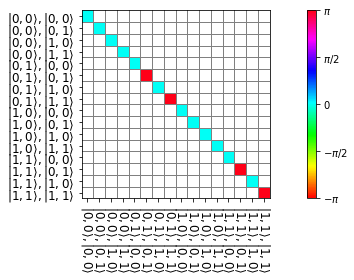

In [11]:
# Gate instructions
#ideal_gate_single = qt_utils.np_kron_n([constants.Id, constants.GATES["rx90p"]])
#ideal_gate_single = gates.GATES["iswap"]
#ideal_gate = np.array(
#    [[1, 0, 0, 0], [0, 0, 0, 1j], [0, 0, 1, 0], [0, 1j, 0, 0]], dtype=np.complex128
#)
#ideal_gate_Unity = qt_utils.np_kron_n([constants.Id, constants.Id])
#ideal_gate_Z = qt_utils.np_kron_n([constants.Id, constants.Z])
#ideal_gate = qt_utils.np_kron_n([ideal_gate_Unity, ideal_gate_Unity])
#ideal_gate = scipy.linalg.block_diag([ideal1, ideal_gate_Unity])
ideal_gate = custom_gates.GATE_CZ_t1q2_t2q2
#ideal_gate = constants.GATES["cx"]
printMatrix(ideal_gate, level_labels, "ideal_gate", output)

gate = gates.Instruction(
    name="cz_t1_t2",
    #name="unity",
    targets=[0, 1],
    t_start=0.0,
    t_end=t_final,
    channels=[d.name for d in drives],
    ideal=ideal_gate,
)
for drive in drives:
    for env in envelopesForDrive[drive.name]:
        gate.add_component(copy.deepcopy(env), drive.name)
    for carrier in carriersForDrive[drive.name]:
        gate.add_component(copy.deepcopy(carrier), drive.name)

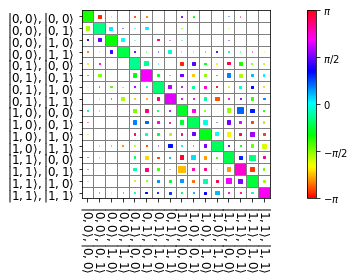

peaks: d1
	4.764238e+09 (amp=9.056845e+10)
	3.974199e+09 (amp=1.687267e+11)
	4.516226e+09 (amp=1.974593e+11)
	4.336217e+09 (amp=1.996128e+11)
	3.914196e+09 (amp=2.336218e+11)
	3.932197e+09 (amp=2.563781e+11)
	3.964198e+09 (amp=2.725071e+11)
	4.434222e+09 (amp=3.448014e+11)
	3.956198e+09 (amp=3.537779e+11)
	4.524226e+09 (amp=3.655127e+11)


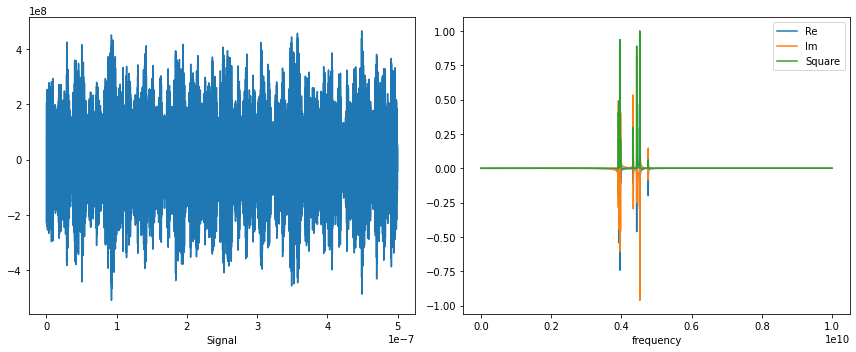

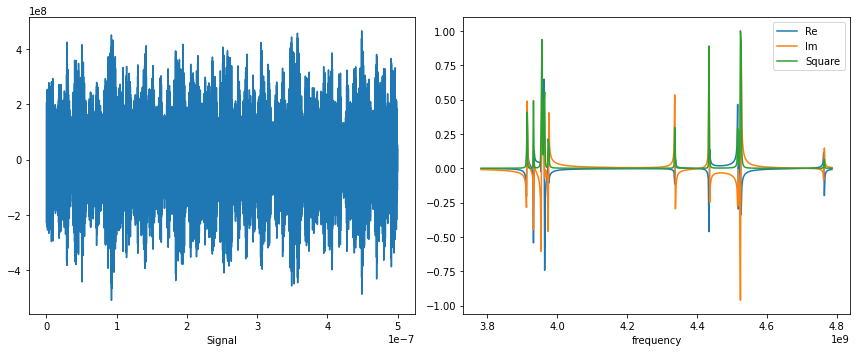

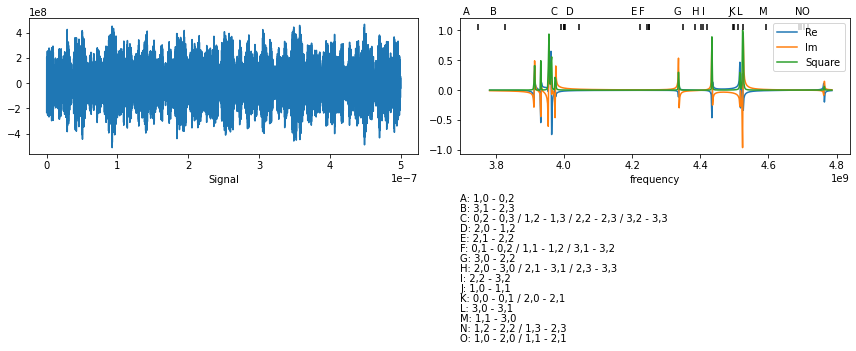

peaks: d2
	2.396120e+09 (amp=1.562652e+08)
	4.404220e+09 (amp=3.017802e+09)
	4.412221e+09 (amp=4.412682e+09)
	4.496225e+09 (amp=7.518097e+09)
	4.488224e+09 (amp=1.244265e+10)
	4.540227e+09 (amp=1.628029e+10)
	4.514226e+09 (amp=6.087030e+10)
	4.504225e+09 (amp=9.729833e+10)
	4.474224e+09 (amp=1.377701e+11)
	4.528226e+09 (amp=1.919244e+11)


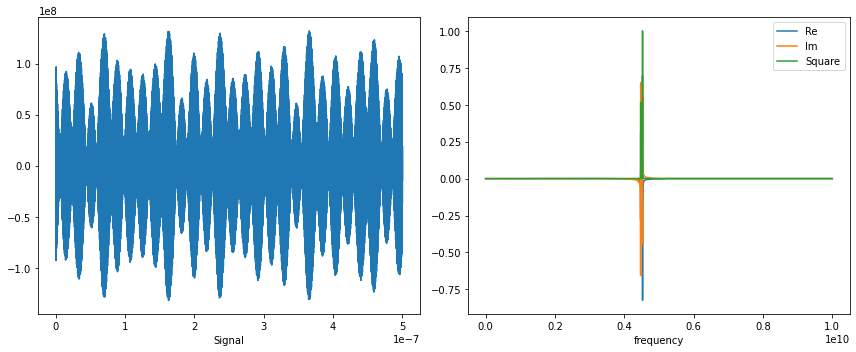

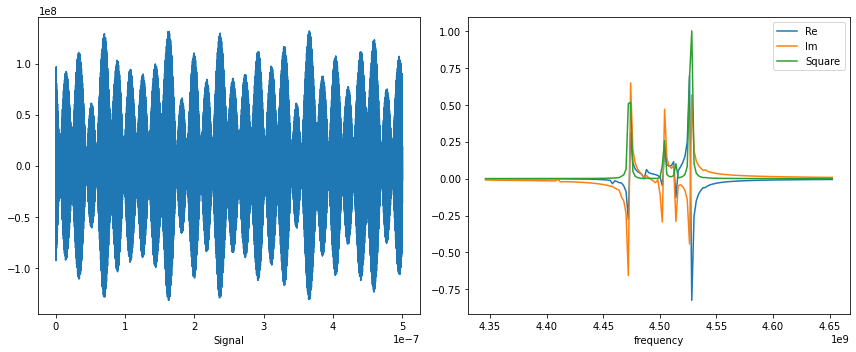

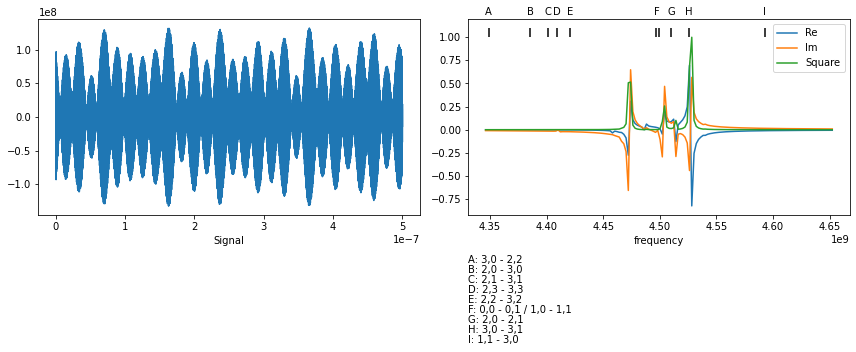

In [12]:
# Set up the experiment
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map, sim_res=sim_res)
exp.set_opt_gates([gate.get_key()])

unitaries = exp.compute_propagators()
printPropagator(exp, gate, level_labels_with_leakage, output)
#printAllSignals(exp, qubits[0], output, directory="devices_before")
#printAllSignals(exp, qubits[1], output, directory="devices_before")
printSignal(exp, qubits, gate, output=output, states=transitions)
#printMatrix(model.get_Hamiltonian(), level_labels_with_leakage, 'Hamiltonian', output)
#printMatrix(model.get_Hamiltonian() / np.max(model.get_Hamiltonian()), level_labels_with_leakage, 'Hamiltonian_scaled', output)

In [ ]:
'''
signals = exp.pmap.generator.generate_signals(gate)
for i, qubit in enumerate(qubits):
    # generate signal
    drive = getDrive(exp.pmap.model, qubit).name
    signal = signals[drive]
    ts = signal["ts"].numpy()
    values = signal["values"].numpy()

    signal2 = stored_signal[drive]
    ts2 = signal2["ts"].numpy()
    values2 = signal2["values"].numpy()

    diffValues = values - values2
    print(values)
    print(values2)
    print(diffValues)
    plt.figure()
    n = 30
    plt.plot(ts[:n], values[:n], label='PWC')
    plt.plot(ts[:n], values2[:n], label='fourier')
    plt.plot(ts[:n], diffValues[:n])
    plt.legend()
    plt.show()
'''

In [ ]:
# Specify the initial state
psi_init = [[0] * model.tot_dim]
for i in entanglementInitStateFull:
    psi_init[0][i] = 1
psi_init /= np.linalg.norm(psi_init)
print("initial state: ", psi_init)
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [gate.get_key()]

printTimeEvolution(exp, init_state, gate, level_labels, output)
#printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))

In [ ]:
# Specify the parameters to be optimised and initialise the optimiser
opt_map = []
for drive in drives:
    for env in envelopesForDrive[drive.name]:
        opt_map.append([(gate.get_key(), drive.name, env.name, "amp")])
        opt_map.append([(gate.get_key(), drive.name, env.name, "freq_offset")])
        opt_map.append([(gate.get_key(), drive.name, env.name, "xy_angle")])
        if useDRAG:
            opt_map.append([(gate.get_key(), drive.name, env.name, "delta")])
        if usePWC:
            opt_map.append([(gate.get_key(), drive.name, env.name, "inphase")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "quadrature")])
            #opt_map.append([(gate.get_key(), drive.name, env.name, "t_bin_end")])
        else:
            opt_map.append([(gate.get_key(), drive.name, env.name, "amps")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "freqs")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "phases")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "t_final")])
    #for carrier in carriersForDrive[drive.name]:
    #    opt_map.append([(gate.get_key(), drive.name, carrier.name, "freq")])
    #    #opt_map.append([(gate.get_key(), drive.name, carrier.name, "framechange")])
parameter_map.set_opt_map(opt_map)
parameter_map.print_parameters()

In [ ]:
infidelities = []

for algorithm in selected_algorithms:
    if algorithm == ALGORITHM_LBFGS:
        infidelities = optimise(output, qubits, exp, algorithms.lbfgs, {
            "maxfun": 3000,
            "ftol": 1e-5
        }, gate)
    elif algorithm == ALGORITHM_LBFGS_GRAD_FREE:
        infidelities = optimise(output, qubits, exp, algorithms.lbfgs_grad_free, {
            "maxfun": 500,
            "gtol": 1e-4,
            "ftol": 1e-4
        }, gate)
    elif algorithm == ALGORITHM_CMAES:
        infidelities = optimise(output, qubits, exp, algorithms.cmaes, {
            "popsize": 15,
            "spread": 0.02,
            "maxfevals": 2000,
            "init_point": "True",
            "stop_at_sigma": 1e-3,
            "stop_at_convergence": 20
        }, gate)
    elif algorithm == ALGORITHM_GCMAES:
        infidelities = optimise(output, qubits, exp, algorithms.gcmaes, {
            "cmaes": {"popsize": 12, "spread": 0.05, "maxfevals": 20,
                      "init_point": "True", "stop_at_sigma": 1e-4, "stop_at_convergence": 20},
            "lbfgs": {"maxfun": 500, "ftol": 1e-6}
        }, gate)
    else:
        print("Unknown algorithm: ", algorithm)

In [ ]:
# Plot results
output = DataOutput(output_dir, file_suffix='after')
plotData(np.arange(len(infidelities)), infidelities, xlabel="Step",
         ylabel="Infidelity", filename=output.createFileName("convergence", "svg"))
printSignal(exp, qubits, gate, output=output, states=transitions)
#printAllSignals(exp, qubits, output, directory="devices_after")
printPropagator(exp, gate, level_labels_with_leakage, output, savePartials=False)
printTimeEvolution(exp, init_state, gate, level_labels, output)
#printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))